In [13]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

device = "gpu" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Device: gpu
PyTorch version: 1.12.0


### PyTorch Workflow

#### 1. Data (preparing and loading)

In [14]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [15]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

##### 1.1. Split data into training and test sets

In [16]:
# create train/test split
train_split = int(0.8 * len(X))

# 80% of data used for training set
X_train, y_train = X[:train_split], y[:train_split]

# 20% for testing 
X_test, y_test = X[train_split:], y[train_split:]

In [17]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

##### 1.2. Visualizing

In [18]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plot training, test data, and predictions
    """

    plt.figure(figsize=(10,10))

    # plot training data in red
    plt.scatter(train_data, train_labels, c="r", label="Training data")

    # plot test data in blue
    plt.scatter(test_data, test_labels, c="b", label="Testing data")

    # plot predictions in green
    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", label="Prediction")

    plt.legend()



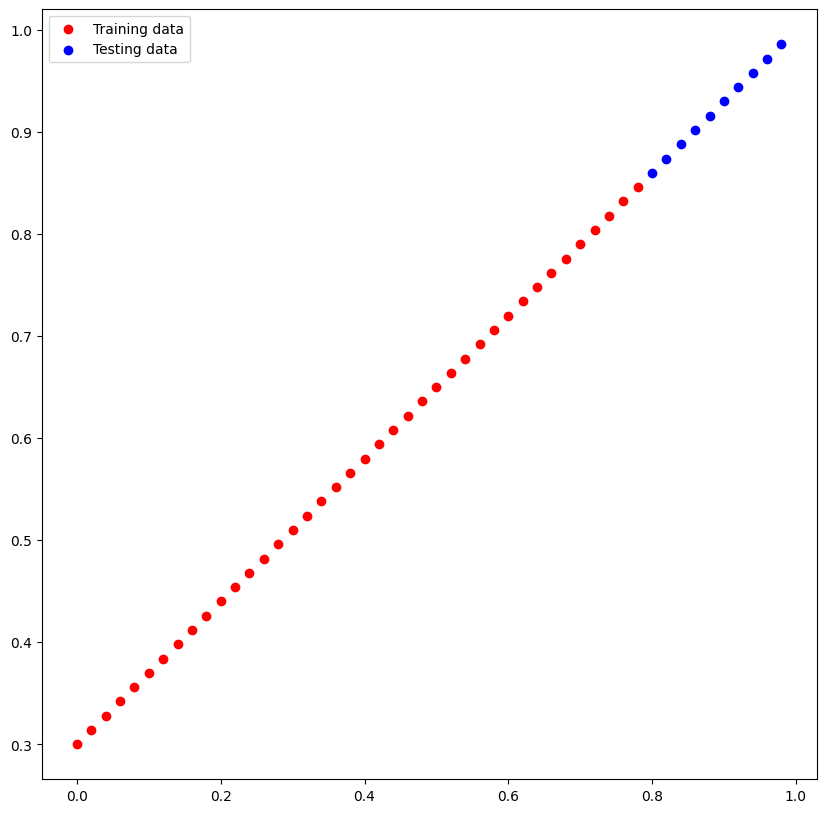

In [19]:
# display
plot_predictions(X_train, y_train, X_test, y_test, None)

#### 2. Building model

In [20]:
# create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    # forard defines the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # y = m*x + b

##### 2.1. PyTorch model building essentials

PyTorch has 4 essential modules to create almost any kind of neural network
- torch.nn
- torch.optim
- torch.utils.data.Dataset
- torch.utils.data.DataLoader

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 

##### 2.2. Checking the content of a PyTorch model

In [21]:
# checking the content of a PyTorch model
torch.manual_seed(42)

# create an instance of the model 
# this is a subclass of nn.Module that contains nn.Parameter
model_0 = LinearRegressionModel()

# check the nn.Parameter(s) within the nn.Module subclass
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [22]:
# get the state by .state_dict()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

> **Exercise:** Try changing the `torch.manual_seed()` value two cells above, see what happens to the weights and bias values. 

In [23]:
# changing a new value for manual_seed
torch.manual_seed(1234)

# create an instance of the model 
# this is a subclass of nn.Module that contains nn.Parameter
model_0 = LinearRegressionModel()

# check the nn.Parameter(s) within the nn.Module subclass
list(model_0.parameters())

[Parameter containing:
 tensor([0.0461], requires_grad=True),
 Parameter containing:
 tensor([0.4024], requires_grad=True)]

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.0461])), ('bias', tensor([0.4024]))])

##### 2.3. Making predictions using torch.inference_mode()

In [25]:
# make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [26]:
# check predictions
len(X_test), len(y_preds)

(10, 10)

In [27]:
# predicted values
y_preds

tensor([[0.4393],
        [0.4402],
        [0.4412],
        [0.4421],
        [0.4430],
        [0.4439],
        [0.4448],
        [0.4458],
        [0.4467],
        [0.4476]])

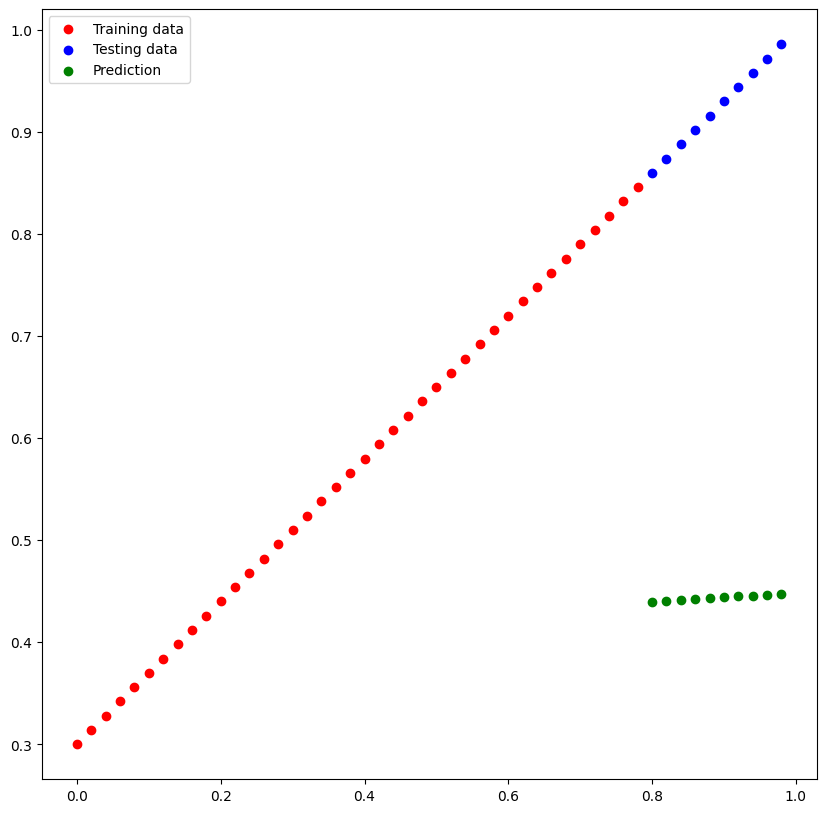

In [28]:
# display
plot_predictions(predictions=y_preds)

In [29]:
# the difference
y_test - y_preds

tensor([[0.4207],
        [0.4338],
        [0.4468],
        [0.4599],
        [0.4730],
        [0.4861],
        [0.4992],
        [0.5122],
        [0.5253],
        [0.5384]])

#### 3. Train model

> https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

In [30]:
# create the loss function
loss_fn = nn.L1Loss() # ~ MAE (Mean absolue error)

# create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

##### 3.1. Creating an optimazation loop in PyTorch

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

##### 3.2 PyTorch training loop

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

##### 3.3. PyTorch testing loop

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

##### 3.4. Start training

**Epochs: 100**

In [31]:
torch.manual_seed(42)

# num of epochs
epochs = 100

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    ## training --------
    
    # training mode
    model_0.train()

    # forward pass on train data
    y_pred = model_0(X_train)

    # calculate the loss
    loss = loss_fn(y_pred, y_train)

    # zero grad of the optimizer
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # progress the optimizer
    optimizer.step()


    ## tesing --------

    with torch.inference_mode():

        # forward pass on test data
        test_pred = model_0(X_test)

        # calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # # predictions come in torch.float datatype

        # print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch) 
            train_loss_values.append(loss.detach().numpy())   
            test_loss_values.append(test_loss.detach().numpy())   

            print(f"Epoch: {epoch} | MAE train loss: {loss} | MAE test loss: {test_loss}")

Epoch: 0 | MAE train loss: 0.175259068608284 | MAE test loss: 0.4703192710876465
Epoch: 10 | MAE train loss: 0.14054274559020996 | MAE test loss: 0.3943885862827301
Epoch: 20 | MAE train loss: 0.12336250394582748 | MAE test loss: 0.34093621373176575
Epoch: 30 | MAE train loss: 0.11418662220239639 | MAE test loss: 0.3033568263053894
Epoch: 40 | MAE train loss: 0.10851772129535675 | MAE test loss: 0.27688518166542053
Epoch: 50 | MAE train loss: 0.10425390303134918 | MAE test loss: 0.25774693489074707
Epoch: 60 | MAE train loss: 0.10049265623092651 | MAE test loss: 0.2433370053768158
Epoch: 70 | MAE train loss: 0.09700265526771545 | MAE test loss: 0.2323170155286789
Epoch: 80 | MAE train loss: 0.0935126468539238 | MAE test loss: 0.22129695117473602
Epoch: 90 | MAE train loss: 0.09002266079187393 | MAE test loss: 0.21027691662311554


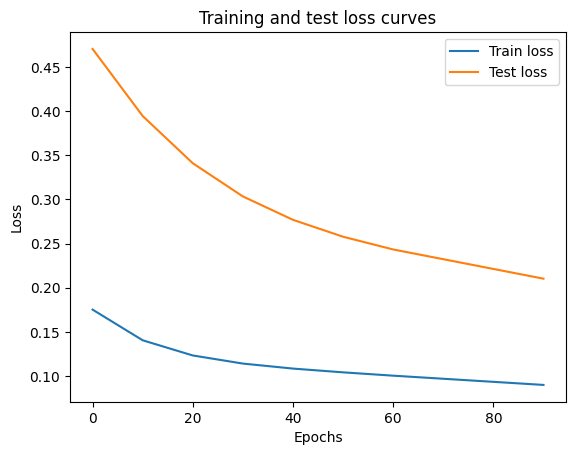

In [32]:
# plot the loss cursves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [33]:
# find model's leaned parameters
learned_weights = model_0.state_dict()["weights"].numpy()
learned_bias = model_0.state_dict()["bias"].numpy()
print(f"Learned Weights: {learned_weights}, learned bias: {learned_bias}")
print(f"Original Weights: {weight}, original bias: {bias}")



Learned Weights: [0.26930052], learned bias: [0.48090306]
Original Weights: 0.7, original bias: 0.3


> **Exercise:** Try changing the `epochs` value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

**Epochs: 200**

In [34]:
torch.manual_seed(42)

# num of epochs
epochs = 200

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    ## training --------
    
    # training mode
    model_0.train()

    # forward pass on train data
    y_pred = model_0(X_train)

    # calculate the loss
    loss = loss_fn(y_pred, y_train)

    # zero grad of the optimizer
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # progress the optimizer
    optimizer.step()


    ## tesing --------

    with torch.inference_mode():

        # forward pass on test data
        test_pred = model_0(X_test)

        # calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # # predictions come in torch.float datatype

        # print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch) 
            train_loss_values.append(loss.detach().numpy())   
            test_loss_values.append(test_loss.detach().numpy())   

            print(f"Epoch: {epoch} | MAE train loss: {loss} | MAE test loss: {test_loss}")

Epoch: 0 | MAE train loss: 0.08657152950763702 | MAE test loss: 0.2020043432712555
Epoch: 10 | MAE train loss: 0.08314309269189835 | MAE test loss: 0.19373181462287903
Epoch: 20 | MAE train loss: 0.07970624417066574 | MAE test loss: 0.18545925617218018
Epoch: 30 | MAE train loss: 0.07626959681510925 | MAE test loss: 0.1778736114501953
Epoch: 40 | MAE train loss: 0.07284115254878998 | MAE test loss: 0.16960108280181885
Epoch: 50 | MAE train loss: 0.06940262764692307 | MAE test loss: 0.16132852435112
Epoch: 60 | MAE train loss: 0.06596765667200089 | MAE test loss: 0.15374287962913513
Epoch: 70 | MAE train loss: 0.06253781169652939 | MAE test loss: 0.14547033607959747
Epoch: 80 | MAE train loss: 0.05909900739789009 | MAE test loss: 0.13719777762889862
Epoch: 90 | MAE train loss: 0.055665720254182816 | MAE test loss: 0.12961213290691376
Epoch: 100 | MAE train loss: 0.052234191447496414 | MAE test loss: 0.1213395819067955
Epoch: 110 | MAE train loss: 0.04879538714885712 | MAE test loss: 0.1

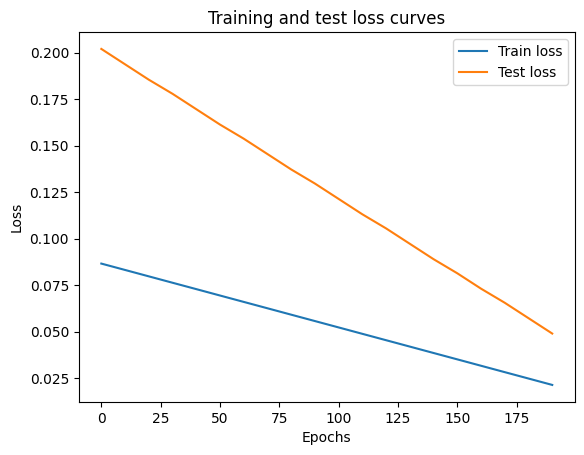

In [35]:
# plot the loss cursves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [36]:
# find model's leaned parameters
learned_weights = model_0.state_dict()["weights"].numpy()
learned_bias = model_0.state_dict()["bias"].numpy()
print(f"Learned Weights: {learned_weights}, learned bias: {learned_bias}")
print(f"Original Weights: {weight}, original bias: {bias}")

Learned Weights: [0.6110318], learned bias: [0.3374049]
Original Weights: 0.7, original bias: 0.3


The model got very close to calculate the exact original values for `weight` and `bias`

#### 4. Making predictions with a trained PyTorch model (inference)

In [37]:
# set the model in evaluation mode
model_0.eval()

# setup the inference mode context manager
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8262],
        [0.8385],
        [0.8507],
        [0.8629],
        [0.8751],
        [0.8873],
        [0.8996],
        [0.9118],
        [0.9240],
        [0.9362]])

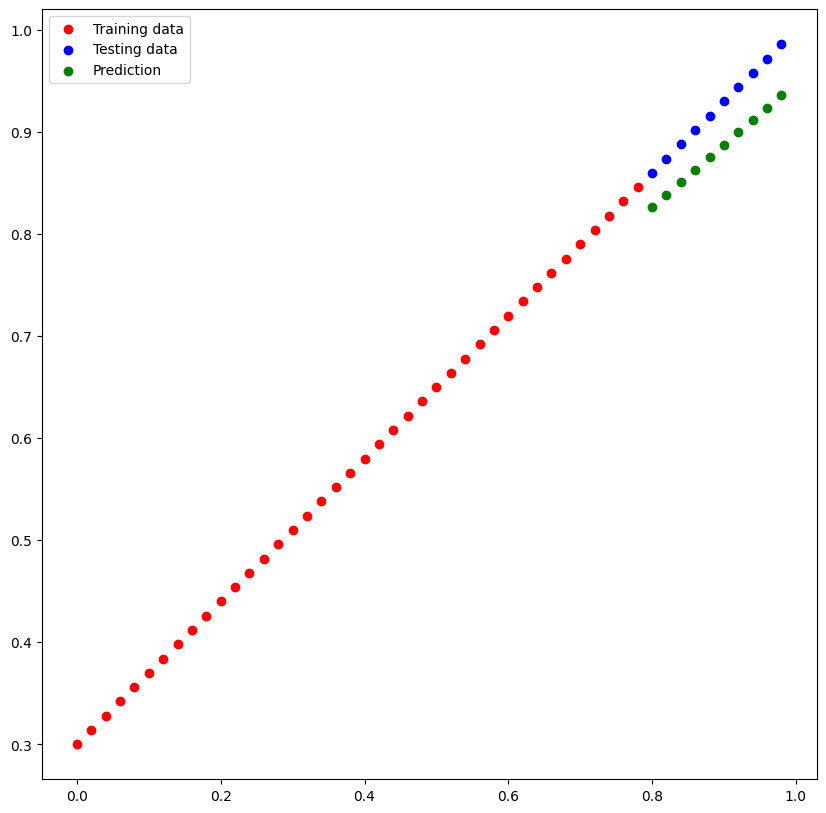

In [38]:
# plot predictions
plot_predictions(predictions=y_preds)

#### 5. Saving and loading a PyTorch model

##### 5.1. Saving a PyTorch model's state_dict()

> The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

In [39]:
from pathlib import Path

# create models directory
MODEL_PATH = Path("../logs/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
# only saving the state_dict() only saves the models learned parameters
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: ../logs/models/01_pytorch_workflow_model_0.pth


In [40]:
# check the saved file path
!ls -l ../logs/models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 jason jason 1063 Jun 14 17:37 ../logs/models/01_pytorch_workflow_model_0.pth


##### 5.2. Loading a saved PyTorch model's state_dict()

In [41]:
# instantiate a new instance of our model
loaded_model_0 = LinearRegressionModel()

# load the state_dict of our saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [42]:
# put the loaded model into evaluation mode
loaded_model_0.eval()

# use the inference mode
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8262],
        [0.8385],
        [0.8507],
        [0.8629],
        [0.8751],
        [0.8873],
        [0.8996],
        [0.9118],
        [0.9240],
        [0.9362]])

In [43]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

#### 6. Putting it all together

In [44]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.0'

In [45]:
# check gpu
device = "GPU" if torch.cuda.is_available() else "CPU"
print(f"Using device: {device}")

Using device: GPU


##### 6.1 Data

In [46]:
# create weight and bias
weight = 0.7
bias = 0.3

# create X and y (features and labels)
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)

y = weight * X + bias


In [47]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [48]:
splitted_data = int(0.8 * len(X))
splitted_data

40

In [49]:
# train_set, test_set
X_train, y_train = X[:splitted_data], y[:splitted_data]

X_test, y_test = X[splitted_data:], y[splitted_data:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

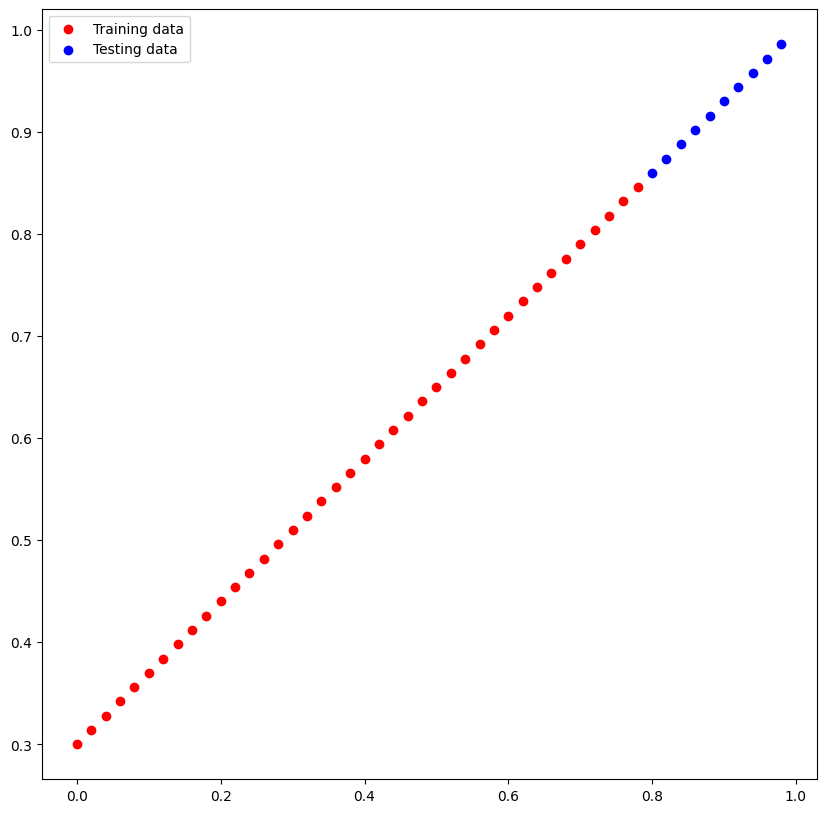

In [51]:
plot_predictions(X_train, y_train, X_test, y_test)

##### 6.2 Building a PyTorch linear model

In [66]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [67]:
# check model device
next(model_1.parameters()).device

device(type='cpu')

In [70]:
# set model to GPU
model_1.to('cuda')
next(model_1.parameters()).device

device(type='cuda', index=0)

##### 6.3 Training

In [74]:
# create loss function
loss_fn = nn.L1Loss()

# create optimizer
# optimize newly created model's parameters
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [77]:
# training loop steps
device = "cuda" if torch.cuda.is_available() else "cpu"

# set manual seed
torch.manual_seed(42)

# num of epochs
epochs = 1000

# put data on the available device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range((epochs)):
    
    ## training ----

    # train mode
    model_1.train()

    # forward pass
    y_pred = model_1(X_train)

    # calculate loss
    loss = loss_fn(y_pred, y_train)

    # zero grad optimizer
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # step the optimizer
    optimizer.step()

    ## testing ----

    # eval mode
    model_1.eval()
    
    # forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # calculate loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
    

Epoch: 0 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 100 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [80]:
from pprint import pprint # pprint = pretty print
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\n And the original values for weights and bias are: ")
print(f"weights: {weight}, bias={bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

 And the original values for weights and bias are: 
weights: 0.7, bias=0.3


##### 6.4 Making predictions

In [81]:
# eval mode
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

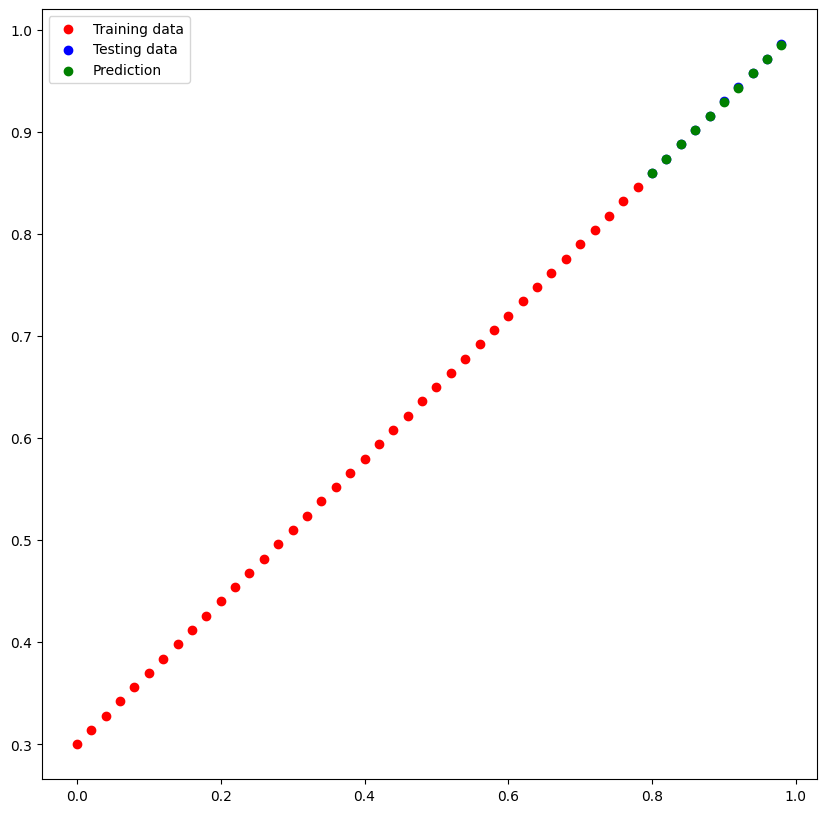

In [83]:
# data not on CPU
# plot_predictions(predictions=y_preds) # won't work

# convert to cpu
plot_predictions(predictions=y_preds.cpu())

##### 6.5 Saving and loading a model

In [84]:
from pathlib import Path

# create models directory 
MODEL_PATH = Path("../logs/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# cave the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [85]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [86]:
loaded_model_1

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [87]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [88]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')